Model from:
https://github.com/NJNischal/Facial-Expression-Recognition-with-CNNs


Imports

In [25]:
import os
import datetime
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
# import imgaug.augmenters as iaa

import tensorflow as tf

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

Debbuging options

In [2]:
# uncomment to log device placement of each operation
# tf.debugging.set_log_device_placement(True)

Check GPU

In [3]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
physical_devices = tf.config.list_physical_devices('GPU')
try:
  tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
  # Invalid device or cannot modify virtual devices once initialized.
  pass

Num GPUs Available:  1


## Parameters

In [4]:
IMG_SIZE=(48,48)
INPUT_SHAPE=IMG_SIZE + (1,)

# Choose resize method. The options are:
# area, bicubic, bilinear, gaussian, lanczos3, lanczos5, mitchellcubic, nearest
INTERPOLATION = "bilinear"

BATCH_SIZE=128
MAX_EPOCHS = 100
NUM_CLASSES=7
CLASS_WEIGHTS= {0: 1, 1: 1}
CLASS_NAMES=[]


SEED=1234

Paths

In [5]:
# # choose data directory
TRAIN_DATA_PATH=Path('../images/Training')
VAL_DATA_PATH=Path('../images/PublicTest')
TEST_DATA_PATH=Path('../images/PrivateTest')
# choose logs directory
LOG_DIR = Path('./logs')

In [6]:
# name your experiment
EXPERIMENT = "Facial-Expression-Recognition-with-CNNs"

In [7]:
OUTPUT_DIR = LOG_DIR / EXPERIMENT / 'trial_{:02}'
counter=1
while os.path.exists(str(OUTPUT_DIR).format(counter)):
    counter += 1
OUTPUT_DIR = Path(str(OUTPUT_DIR).format(counter))
os.makedirs(OUTPUT_DIR, exist_ok = True)

In [28]:
summary_filepath = OUTPUT_DIR / 'model.txt'
best_model_filepath = OUTPUT_DIR / f'best_model.h5'
csv_logger_filepath = OUTPUT_DIR / f'training.log'
history_filepath = OUTPUT_DIR / f'training_history.png'
report_filepath = OUTPUT_DIR / 'report.txt'
confusion_matrix_norm_filepath = OUTPUT_DIR / f'confusion_matrix_norm.png'
confusion_matrix_filepath = OUTPUT_DIR / f'confusion_matrix.png'

## DATA INPUT PIPELINE

Load datasets

In [9]:
# !pip install deeplake
# import deeplake
# train_ds = deeplake.load('hub://activeloop/fer2013-train')
# val_ds = deeplake.load('hub://activeloop/fer2013-public-test')
# test_ds = deeplake.load('hub://activeloop/fer2013-private-test')

In [10]:
from keras.preprocessing.image import ImageDataGenerator


train_datagen = ImageDataGenerator()
test_datagen = ImageDataGenerator()


train_ds = train_datagen.flow_from_directory(
    TRAIN_DATA_PATH,
    target_size=IMG_SIZE,
    color_mode='grayscale',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
)

val_ds = test_datagen.flow_from_directory(
    VAL_DATA_PATH,
    target_size=IMG_SIZE,
    color_mode='grayscale',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False,
)

test_ds = test_datagen.flow_from_directory(
    TEST_DATA_PATH,
    target_size=IMG_SIZE,
    color_mode='grayscale',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False,
)


Found 28709 images belonging to 7 classes.
Found 3589 images belonging to 7 classes.
Found 3589 images belonging to 7 classes.


In [11]:
# labels = [np.argmax(y) for x, y in train_ds]
# neg, pos = np.bincount(labels)
# total = neg + pos

# # Scaling by total/2 helps keep the loss to a similar magnitude.
# # The sum of the weights of all examples stays the same.
# weight_for_0 = (1 / neg) * (total / 2.0)
# weight_for_1 = (1 / pos) * (total / 2.0)


# CLASS_WEIGHTS = {0: weight_for_0, 1: weight_for_1}

# print('Weight for class 0: {:.2f}'.format(weight_for_0))
# print('Weight for class 1: {:.2f}'.format(weight_for_1))

Show images

(128, 48, 48, 1)


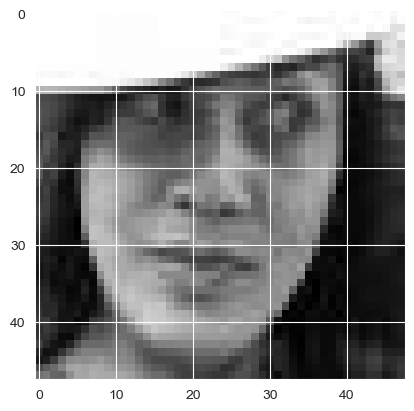

(128, 48, 48, 1)


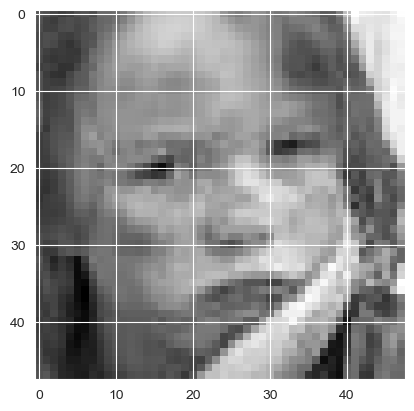

(128, 48, 48, 1)


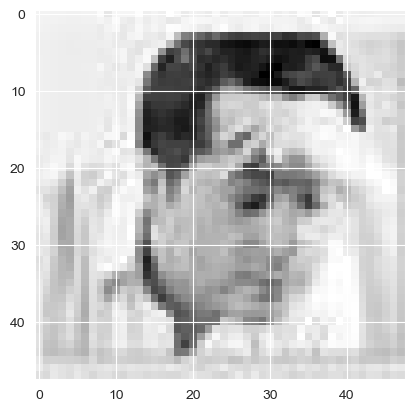

(128, 48, 48, 1)


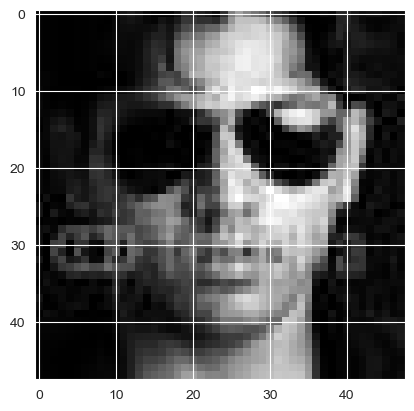

(128, 48, 48, 1)


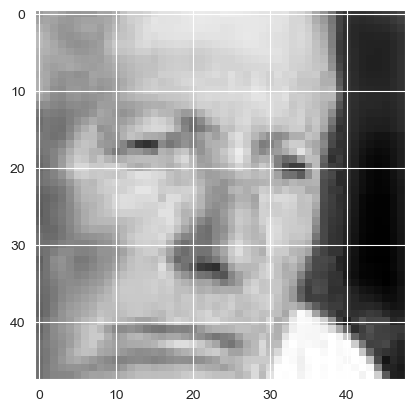

In [12]:
for _ in range(5):
    img, label = train_ds.next()
    print(img.shape)   #  (1,256,256,3)
    plt.imshow(img[0][:,:,0], cmap="gray")
    plt.show()

##### Build model

In [13]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, GlobalAveragePooling2D, GlobalMaxPooling2D
from keras.layers import Flatten, Dense, Dropout, Activation, Resizing, UpSampling2D, Input, BatchNormalization, Rescaling

rescale  = Rescaling(1./255)

model = Sequential([
    Input(shape=(48,48,1)),

    Rescaling(1./255),

    Conv2D(filters=64, kernel_size=(3,3), strides=1, padding='same', activation="relu"),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2,2), strides=2),
    Dropout(0.25),
    
    Conv2D(filters=128, kernel_size=(5,5), strides=1, padding='same', activation="relu"),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2,2), strides=2),
    Dropout(0.25),

    Conv2D(filters=512, kernel_size=(3,3), strides=1, padding='same', activation="relu"),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2,2), strides=2),
    Dropout(0.25),

    Conv2D(filters=512, kernel_size=(3,3), strides=1, padding='same', activation="relu"),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2,2), strides=2),
    Dropout(0.25),

    Flatten(),

    Dense(256),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.5),
    

    Dense(512),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.5),


    Dense(NUM_CLASSES,activation="softmax")
]
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 48, 48, 1)         0         
                                                                 
 conv2d (Conv2D)             (None, 48, 48, 64)        640       
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 64)       256       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 48, 48, 64)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 24, 24, 64)        0

Save model summary

In [14]:
with open(summary_filepath, 'w') as f:
    model.summary(print_fn=lambda x: f.write(x + '\n'))

Compile model

In [15]:
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
              metrics=['accuracy'])

Pre-evaluate model

In [16]:
model.evaluate(test_ds)

29/29 [==============================] - 11s 118ms/step - loss: 1.9507 - accuracy: 0.0156


[1.9507452249526978, 0.015603232197463512]

Callbacks

In [17]:
save_checkpoint = tf.keras.callbacks.ModelCheckpoint(monitor='val_loss', save_best_only=True, filepath=best_model_filepath)
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1)
csv_logger = tf.keras.callbacks.CSVLogger(filename=csv_logger_filepath)
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=OUTPUT_DIR)


def schedule(epoch) -> float:
    if epoch >= 5:
        return 0.00005
    return 0.0005
reduce_lr = tf.keras.callbacks.LearningRateScheduler(schedule, verbose=0)
# reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=1e-6, verbose=1)


##### Training

In [18]:
history = model.fit(
        train_ds,
        epochs=MAX_EPOCHS,
        validation_data=val_ds,
        callbacks=[save_checkpoint, csv_logger],
        # class_weight=CLASS_WEIGHTS,
        # workers=10,
        # use_multiprocessing=True
    )

Epoch 1/100
225/225 [==============================] - 132s 573ms/step - loss: 2.2259 - accuracy: 0.2016 - val_loss: 1.8410 - val_accuracy: 0.2494
Epoch 2/100
225/225 [==============================] - 41s 183ms/step - loss: 2.0173 - accuracy: 0.2243 - val_loss: 1.8341 - val_accuracy: 0.2494
Epoch 3/100
225/225 [==============================] - 41s 183ms/step - loss: 1.9221 - accuracy: 0.2360 - val_loss: 1.7845 - val_accuracy: 0.2519
Epoch 4/100
225/225 [==============================] - 41s 183ms/step - loss: 1.8502 - accuracy: 0.2552 - val_loss: 1.7635 - val_accuracy: 0.2611
Epoch 5/100
225/225 [==============================] - 41s 183ms/step - loss: 1.8036 - accuracy: 0.2693 - val_loss: 1.7512 - val_accuracy: 0.2717
Epoch 6/100
225/225 [==============================] - 41s 184ms/step - loss: 1.7680 - accuracy: 0.2861 - val_loss: 1.7400 - val_accuracy: 0.2781
Epoch 7/100
225/225 [==============================] - 41s 183ms/step - loss: 1.7341 - accuracy: 0.3085 - val_loss: 1.7158 

Evaluate model

In [19]:
# uncomment to load best model
# model=tf.keras.models.load_model(best_model_filepath)

model.evaluate(test_ds)

29/29 [==============================] - 4s 91ms/step - loss: 1.0254 - accuracy: 0.6294


[1.025431752204895, 0.6294232606887817]

### VISUALIZATION

Loss and accuracy history

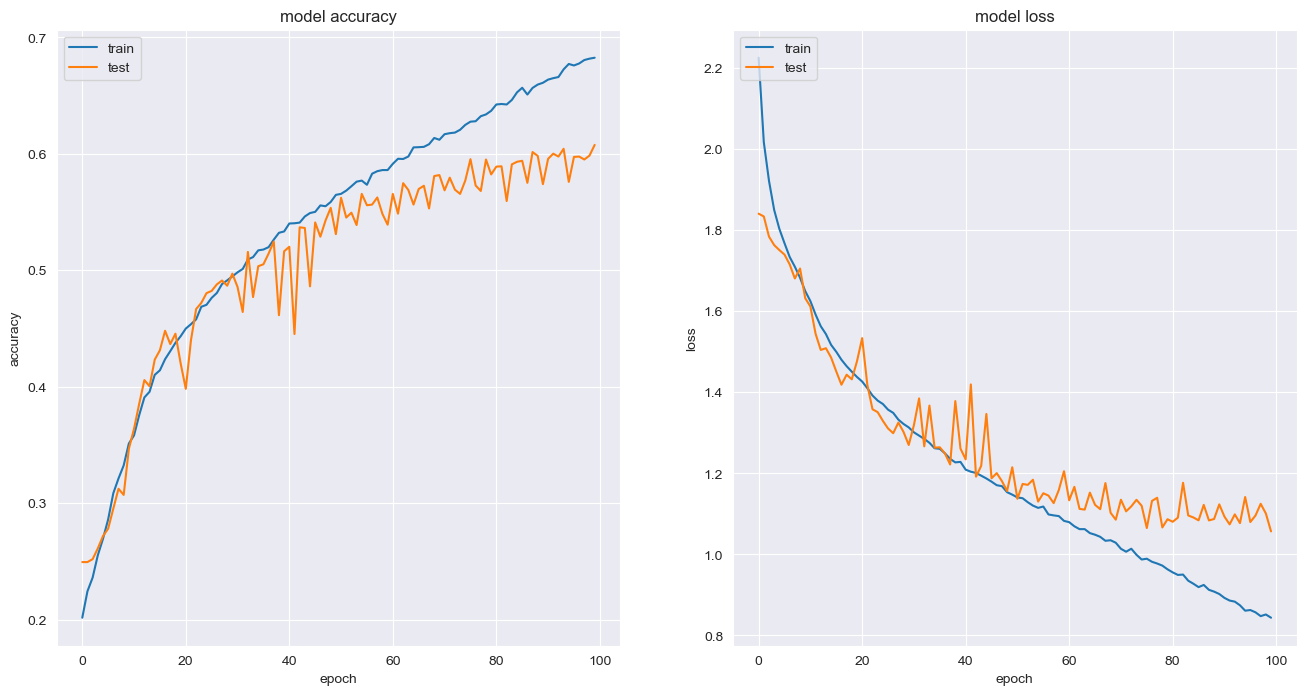

In [33]:
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
# summarize history for loss

plt.subplot(1,2,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

plt.savefig(history_filepath, facecolor='white', bbox_inches='tight')
plt.show()

Trues and predictions

29/29 [==============================] - 4s 71ms/step


<Figure size 640x480 with 0 Axes>

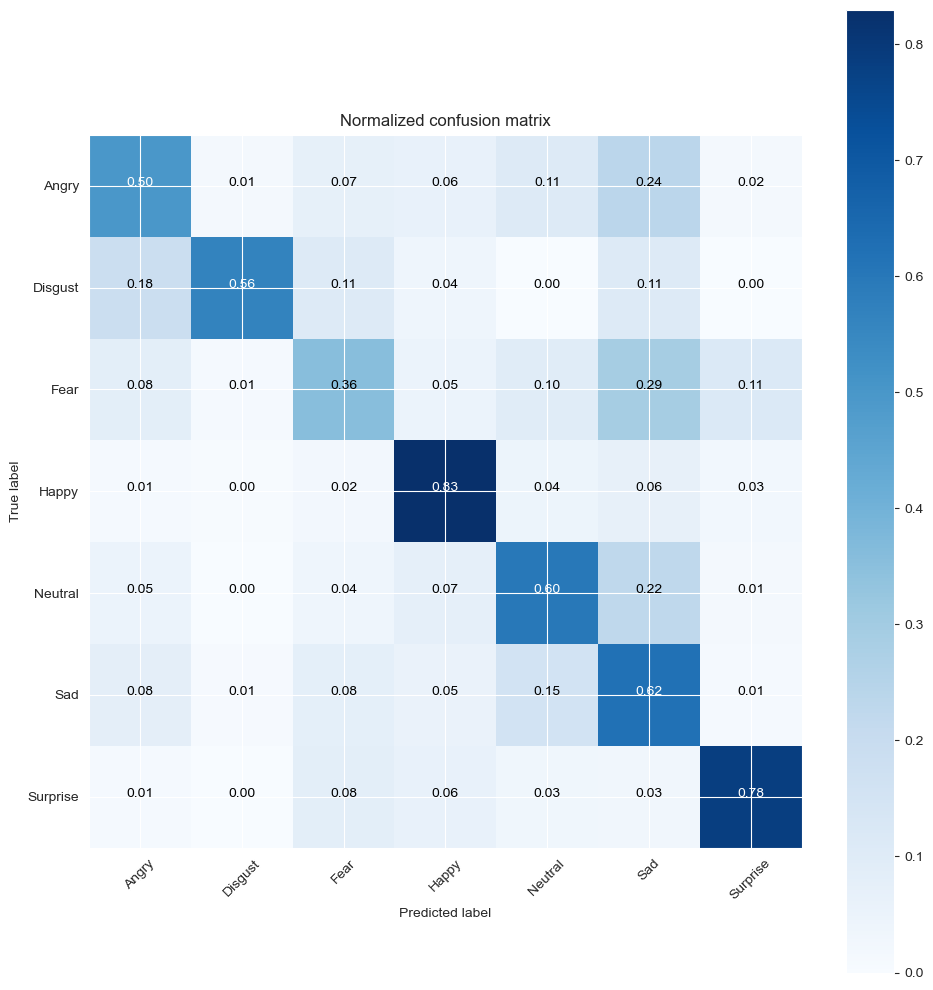

<Figure size 640x480 with 0 Axes>

In [29]:
# show the confusion matrix of our predictions

# compute predictions
predictions = model.predict(test_ds)
preds = [np.argmax(probas) for probas in predictions]
trues = test_ds.classes
class_names = test_ds.class_indices.keys()

from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    
# compute confusion matrix
cnf_matrix = confusion_matrix(trues, preds)
np.set_printoptions(precision=2)

# plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, title='Normalized confusion matrix')
plt.show()
plt.savefig(confusion_matrix_norm_filepath, facecolor='white', bbox_inches='tight')

Classification report

In [30]:
cr=classification_report(trues,preds,target_names=class_names)
cm = np.array2string(confusion_matrix(trues, preds))
with open(report_filepath, 'w') as f:
    f.write(f'Title\n\nClassification Report\n\n{cr}\n\nConfusion Matrix\n\n{cm}\n')

print(cr)

              precision    recall  f1-score   support

       Angry       0.62      0.50      0.55       491
     Disgust       0.56      0.56      0.56        55
        Fear       0.54      0.36      0.43       528
       Happy       0.82      0.83      0.82       879
     Neutral       0.60      0.60      0.60       626
         Sad       0.43      0.62      0.51       594
    Surprise       0.75      0.78      0.77       416

    accuracy                           0.63      3589
   macro avg       0.62      0.61      0.61      3589
weighted avg       0.64      0.63      0.63      3589



Confusion matrix

<Figure size 1000x1000 with 0 Axes>

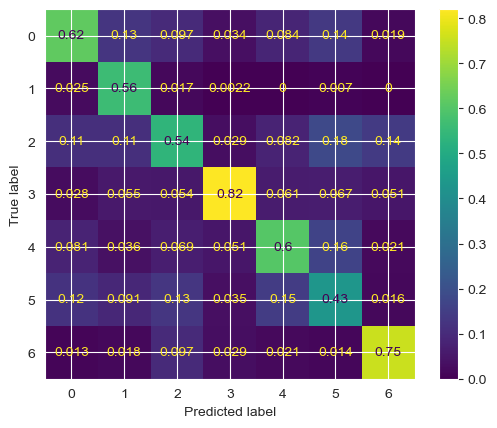

In [31]:
cm=confusion_matrix(trues, preds, normalize='pred')
plt.figure(figsize=(10,10))
np.set_printoptions(precision=2)
disp = ConfusionMatrixDisplay(cm)
disp.plot()
plt.savefig(confusion_matrix_filepath, facecolor='white', bbox_inches='tight')